# Step 0: Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Load & EDA

In [2]:
df = pd.read_csv("output_random.csv")

df = df[['Consumer complaint narrative', 'Product']].dropna()

mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Credit reporting or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}
df = df[df['Product'].isin(mapping.keys())]
df['Category'] = df['Product'].map(mapping)

print("Class Distribution:")
print(df['Category'].value_counts())

Class Distribution:
Category
0    38594
1     6455
3     2367
2      146
Name: count, dtype: int64


# Step 2: Text Preprocessing

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['CleanText'] = df['Consumer complaint narrative'].apply(clean_text)

# Step 3: TF-IDF Vectorization

In [4]:
X = df['CleanText']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 4: Model Selection

In [8]:
import warnings
warnings.filterwarnings("ignore")

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "accuracy": acc,
        "report": report,
        "predictions": y_pred,
        "model": model
    }
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"]))


Logistic Regression Accuracy: 0.9270
                  precision    recall  f1-score   support

Credit Reporting       0.94      0.98      0.96      7719
 Debt Collection       0.83      0.68      0.74      1291
   Consumer Loan       1.00      0.07      0.13        29
        Mortgage       0.91      0.86      0.89       474

        accuracy                           0.93      9513
       macro avg       0.92      0.65      0.68      9513
    weighted avg       0.92      0.93      0.92      9513


Naive Bayes Accuracy: 0.9114
                  precision    recall  f1-score   support

Credit Reporting       0.94      0.96      0.95      7719
 Debt Collection       0.77      0.63      0.69      1291
   Consumer Loan       0.00      0.00      0.00        29
        Mortgage       0.78      0.92      0.85       474

        accuracy                           0.91      9513
       macro avg       0.62      0.63      0.62      9513
    weighted avg       0.91      0.91      0.91      9513

# Step 5: Model Evaluation


Best Model: Random Forest with Accuracy 0.9302


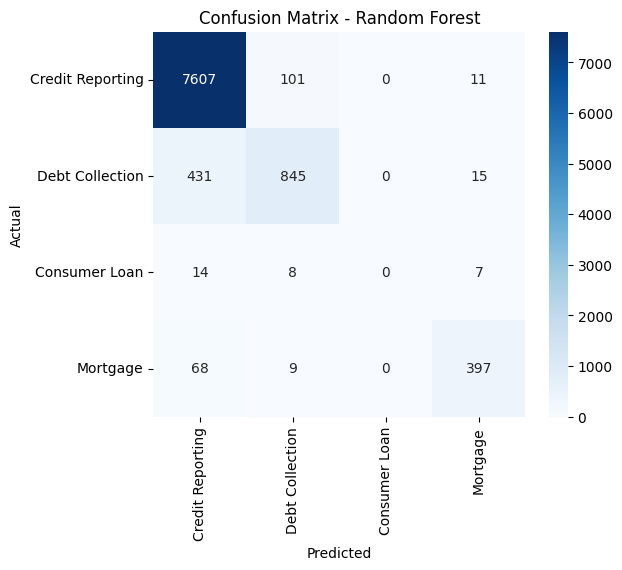

In [6]:
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_pred = results[best_model_name]['predictions']

print(f"\nBest Model: {best_model_name} with Accuracy {results[best_model_name]['accuracy']:.4f}")

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"], yticklabels=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 6: Prediction Examples

In [7]:
import random

sample_idx = random.sample(range(len(X_test)), 10)

sample_texts = X_test.iloc[sample_idx]
sample_true = y_test.iloc[sample_idx]

sample_tfidf = vectorizer.transform(sample_texts)

sample_preds = best_model.predict(sample_tfidf)

print("\nRandom 10 Predictions from Test Dataset:")
for txt, true_label, pred in zip(sample_texts, sample_true, sample_preds):
    print(f"Complaint: {txt[:120]}...")
    print(f"True Category: {true_label} | Predicted Category: {pred}\n")


Random 10 Predictions from Test Dataset:
Complaint: i received calls from xxxx a furniture leasing company about an account which i had no knowledge of the company reached ...
True Category: 1 | Predicted Category: 1

Complaint: i am listing accounts and inquiries below that have been reported inaccurately on my credit report in compliance with th...
True Category: 0 | Predicted Category: 0

Complaint: when my loan closed with franklin loan xxxx in xxxx they collected months of hazard insurance x and months of property t...
True Category: 3 | Predicted Category: 3

Complaint: i am writing to formally dispute several unauthorized credit inquiries that appear on my credit report i have reviewed m...
True Category: 0 | Predicted Category: 0

Complaint: i reviewed my credit report and identified accounts that i am unfamiliar with upon reaching out to request verification ...
True Category: 0 | Predicted Category: 0

Complaint: i consistently ensured timely payments so im puzzled by an err